In [2]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import yaml

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [10]:
import mushroom
from mushroom.mushroom_v3 import Mushroom

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packag

In [11]:
# !pip install vector-quantize-pytorch

In [12]:
import mushroom.utils as utils

In [13]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [18]:
mushroom_config = {
    'dtype': 'visium',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'triplet_scaler': .0001,
        'recon_scaler': 1.,
        'encoder_dim': 256,
        'decoder_dim': 256,
    },
    'learner_kwargs': {
        'scale': .1,
        'pct_expression': .02,
        'batch_size': 32,
        'num_workers': 1,
        'device': 'cuda:3',
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 10000,
#         'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True,
        'centroids': None,
    }
}

In [19]:
# for config_fp in config_fps:
#     config = yaml.safe_load(open(config_fp))
#     case = config_fp.split('/')[-2]
#     print(case)
    
#     out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}/outputs')
#     chkpt_dir = os.path.join(out_dir, 'chkpts')
#     Path(chkpt_dir).mkdir(parents=True, exist_ok=True)
    
#     mushroom_config['sections'] = config
#     mushroom_config['train_kwargs']['save_dir'] = chkpt_dir
    
#     mushroom = Mushroom.from_config(mushroom_config)
    
#     mushroom.train()
#     mushroom.chkpt_filepath = ''
#     mushroom.embed_sections()
#     mushroom.cluster_sections(margin=.05)

#     mushroom.save_config(os.path.join(out_dir, 'mushroom_config.yaml'))
#     mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))
    
# #     break
    
    

In [20]:
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml'
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml'
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'
config = yaml.safe_load(open(config_fp))
case = config_fp.split('/')[-2]

out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}_vae_v3/outputs')
chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [36]:
out_dir

'/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1_vae_v3/outputs'

In [21]:
mushroom_config['sections'] = config
mushroom_config['train_kwargs']['save_dir'] = chkpt_dir

In [22]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda:3
INFO:root:generating inputs for visium tissue sections
INFO:root:using 11622 channels
INFO:root:2 sections detected: ['s0', 's3']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer
INFO:root:no background channel detected, defaulting to mean of all channels


In [23]:
# %%time
# b = next(iter(mushroom.learner.train_dl))

In [24]:
# device = mushroom.learner.device
# img_x = torch.stack((b['anchor_img'], b['pos_img'], b['neg_img']))
# section_x = torch.stack((b['anchor_idx'], b['pos_idx'], b['neg_idx']))
# img_x, section_x = img_x.to(device), section_x.to(device)

# losses, outputs = mushroom.learner.sae(img_x, section_x)

In [25]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(0.5540, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5474, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(66.1149, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1_vae_v3/outputs/chkpts/0iter.pt
INFO:root:iteration 10: {'overall_loss': tensor(0.3978, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3889, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(88.7396, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 20: {'overall_loss': tensor(0.3529, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3455, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(73.8549, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 30: {'overall_loss': tensor(0.4246, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.4181, device='cuda:3', gra

INFO:root:iteration 340: {'overall_loss': tensor(0.2163, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2137, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(25.1436, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 350: {'overall_loss': tensor(0.2498, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2471, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(27.4350, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 360: {'overall_loss': tensor(0.2014, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1989, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(24.5632, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 370: {'overall_loss': tensor(0.2518, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2491, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(27.4598, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 380:

INFO:root:iteration 690: {'overall_loss': tensor(0.2565, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2540, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(25.2759, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 700: {'overall_loss': tensor(0.2430, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2407, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(23.3426, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 710: {'overall_loss': tensor(0.2212, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2190, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(21.6049, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 720: {'overall_loss': tensor(0.2479, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2456, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(23.3887, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 730:

INFO:root:iteration 1030: {'overall_loss': tensor(0.2226, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2204, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(21.9527, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1040: {'overall_loss': tensor(0.2593, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2570, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(22.4204, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1050: {'overall_loss': tensor(0.3456, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.3428, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(28.5820, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1060: {'overall_loss': tensor(0.2579, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2556, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(22.7735, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 1370: {'overall_loss': tensor(0.2197, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2173, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(24.1570, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1380: {'overall_loss': tensor(0.2235, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2212, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(23.1691, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1390: {'overall_loss': tensor(0.2508, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2482, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(25.8804, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1400: {'overall_loss': tensor(0.2689, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2662, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(27.0097, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 1710: {'overall_loss': tensor(0.2354, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2321, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(32.2730, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1720: {'overall_loss': tensor(0.2169, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2141, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(28.6324, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1730: {'overall_loss': tensor(0.2216, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2187, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(28.7922, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 1740: {'overall_loss': tensor(0.2102, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2074, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(28.0662, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 2050: {'overall_loss': tensor(0.2381, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2335, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(45.8741, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2060: {'overall_loss': tensor(0.1937, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1899, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(38.2251, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2070: {'overall_loss': tensor(0.2016, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1980, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(36.8700, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2080: {'overall_loss': tensor(0.2057, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2020, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(36.9447, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 2390: {'overall_loss': tensor(0.2096, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2048, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(48.0821, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2400: {'overall_loss': tensor(0.1684, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1638, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(45.7225, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2410: {'overall_loss': tensor(0.1577, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1538, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(38.8193, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2420: {'overall_loss': tensor(0.2171, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.2115, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(56.4534, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 2730: {'overall_loss': tensor(0.1931, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1871, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(60.0796, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2740: {'overall_loss': tensor(0.1749, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1690, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(58.2568, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2750: {'overall_loss': tensor(0.1679, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1621, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(57.2683, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 2760: {'overall_loss': tensor(0.1530, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1480, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(49.7700, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 3070: {'overall_loss': tensor(0.1612, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1551, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(61.0770, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3080: {'overall_loss': tensor(0.1518, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1458, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(60.2544, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3090: {'overall_loss': tensor(0.1705, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1640, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(65.9162, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3100: {'overall_loss': tensor(0.1505, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1445, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(59.7467, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 3410: {'overall_loss': tensor(0.1390, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1331, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(59.0576, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3420: {'overall_loss': tensor(0.1569, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1498, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(70.7751, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3430: {'overall_loss': tensor(0.1066, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1021, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(45.1117, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3440: {'overall_loss': tensor(0.1490, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1425, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(64.9596, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 3750: {'overall_loss': tensor(0.1472, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1404, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(68.0733, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3760: {'overall_loss': tensor(0.1285, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1220, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(64.8873, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3770: {'overall_loss': tensor(0.1259, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1200, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(58.3050, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 3780: {'overall_loss': tensor(0.1353, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1285, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(67.5456, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 4090: {'overall_loss': tensor(0.1688, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1603, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(84.7857, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 4100: {'overall_loss': tensor(0.1448, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1380, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(68.2300, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 4110: {'overall_loss': tensor(0.1182, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1122, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(60.8781, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 4120: {'overall_loss': tensor(0.1231, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1168, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(63.5804, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 4430: {'overall_loss': tensor(0.1426, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1352, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(74.1595, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 4440: {'overall_loss': tensor(0.1114, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1052, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(62.2634, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 4450: {'overall_loss': tensor(0.1212, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1147, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(65.0386, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 4460: {'overall_loss': tensor(0.1239, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1165, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(74.2224, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 4770: {'overall_loss': tensor(0.1064, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0999, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(65.1828, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 4780: {'overall_loss': tensor(0.1363, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1286, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(77.2161, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 4790: {'overall_loss': tensor(0.1128, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1058, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(69.8016, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 4800: {'overall_loss': tensor(0.1267, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1195, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(71.8156, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 5110: {'overall_loss': tensor(0.0967, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0907, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(60.3350, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 5120: {'overall_loss': tensor(0.1170, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.1096, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(73.4167, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 5130: {'overall_loss': tensor(0.0988, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0923, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(65.2400, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 5140: {'overall_loss': tensor(0.1014, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0945, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(68.6690, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 5450: {'overall_loss': tensor(0.1070, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0998, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(71.8208, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 5460: {'overall_loss': tensor(0.0978, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0914, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(63.6935, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 5470: {'overall_loss': tensor(0.0968, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0902, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(66.3285, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 5480: {'overall_loss': tensor(0.0936, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0869, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(67.2210, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 5790: {'overall_loss': tensor(0.1004, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0936, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(68.1160, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 5800: {'overall_loss': tensor(0.0799, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0742, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(56.9282, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 5810: {'overall_loss': tensor(0.0898, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0834, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(63.8139, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 5820: {'overall_loss': tensor(0.0674, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0626, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(47.7360, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 6130: {'overall_loss': tensor(0.0780, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0719, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(61.1002, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 6140: {'overall_loss': tensor(0.0803, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0745, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(57.8721, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 6150: {'overall_loss': tensor(0.0907, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0842, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(65.0861, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 6160: {'overall_loss': tensor(0.0962, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0896, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(65.8625, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 6470: {'overall_loss': tensor(0.0961, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0886, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(74.7721, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 6480: {'overall_loss': tensor(0.0995, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0921, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(73.6702, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 6490: {'overall_loss': tensor(0.0779, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0718, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(60.7986, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 6500: {'overall_loss': tensor(0.0986, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0913, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(73.2979, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 6810: {'overall_loss': tensor(0.0714, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0655, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(58.7550, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 6820: {'overall_loss': tensor(0.0887, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0817, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(69.8085, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 6830: {'overall_loss': tensor(0.0728, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0666, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(62.0390, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 6840: {'overall_loss': tensor(0.0896, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0828, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(67.6314, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 7150: {'overall_loss': tensor(0.0792, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0732, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(60.2488, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 7160: {'overall_loss': tensor(0.1084, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0996, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(87.9903, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 7170: {'overall_loss': tensor(0.0924, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0852, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(72.2556, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 7180: {'overall_loss': tensor(0.0866, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0796, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(70.0339, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 7490: {'overall_loss': tensor(0.0788, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0719, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(68.1963, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 7500: {'overall_loss': tensor(0.1056, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0975, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(80.7099, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 7510: {'overall_loss': tensor(0.0650, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0596, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(54.2325, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 7520: {'overall_loss': tensor(0.0773, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0708, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(64.9888, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 7830: {'overall_loss': tensor(0.0728, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0665, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(62.9000, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 7840: {'overall_loss': tensor(0.0803, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0734, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(69.6144, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 7850: {'overall_loss': tensor(0.0919, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0844, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(74.4467, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 7860: {'overall_loss': tensor(0.0868, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0790, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(77.6363, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 8170: {'overall_loss': tensor(0.0842, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0769, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(73.5234, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 8180: {'overall_loss': tensor(0.0846, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0777, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(69.1412, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 8190: {'overall_loss': tensor(0.0822, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0753, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(68.2756, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 8200: {'overall_loss': tensor(0.0829, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0756, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(73.4760, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 8510: {'overall_loss': tensor(0.0801, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0729, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(71.8790, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 8520: {'overall_loss': tensor(0.0682, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0622, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(59.4974, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 8530: {'overall_loss': tensor(0.0704, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0638, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(66.5242, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 8540: {'overall_loss': tensor(0.0885, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0805, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(80.0144, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 8850: {'overall_loss': tensor(0.0671, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0613, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(57.6324, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 8860: {'overall_loss': tensor(0.0823, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0749, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(73.4618, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 8870: {'overall_loss': tensor(0.0876, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0802, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(73.7538, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 8880: {'overall_loss': tensor(0.0735, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0669, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(66.6245, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 9190: {'overall_loss': tensor(0.0575, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0524, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(51.1313, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 9200: {'overall_loss': tensor(0.0808, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0731, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(77.0838, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 9210: {'overall_loss': tensor(0.0759, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0692, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(67.8986, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 9220: {'overall_loss': tensor(0.0678, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0618, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(60.1487, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 9530: {'overall_loss': tensor(0.0570, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0514, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(55.7098, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 9540: {'overall_loss': tensor(0.0732, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0661, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(70.7955, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 9550: {'overall_loss': tensor(0.0587, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0532, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(55.3669, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 9560: {'overall_loss': tensor(0.0774, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0699, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(75.2121, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

INFO:root:iteration 9870: {'overall_loss': tensor(0.0597, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0541, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(56.0861, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 9880: {'overall_loss': tensor(0.0639, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0578, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(60.9535, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 9890: {'overall_loss': tensor(0.0601, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0541, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(60.3522, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 9900: {'overall_loss': tensor(0.0708, device='cuda:3', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.0638, device='cuda:3', grad_fn=<DivBackward0>), 'triplet_loss': tensor(69.6675, device='cuda:3', grad_fn=<DivBackward0>)}
INFO:root:iteration 

In [26]:
mushroom.embed_sections()

In [34]:
mushroom.save_config(os.path.join(out_dir, 'mushroom_config.yaml'))

In [35]:
mushroom.save_outputs(os.path.join(out_dir, 'outputs.pt'))

In [25]:
os.path.join(out_dir, 'outputs.pt')

'/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/outputs.pt'

In [27]:
d = torch.load('/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/outputs.pt')
d.keys()

dict_keys(['recon_embs', 'recon_imgs', 'true_imgs', 'cluster_distances', 'cluster_distance_volume', 'cluster_centroids', 'cluster_ids'])

In [28]:
d['recon_embs']

tensor([[[[ 2.3089e-01,  2.5042e-01,  4.0160e-02,  ...,  2.5042e-01,
            4.0160e-02,  3.1269e-01],
          [ 2.5726e-01,  6.5795e-02,  1.8909e-01,  ...,  6.5795e-02,
            1.8909e-01,  2.5140e-01],
          [ 1.2537e-01,  2.7679e-01,  1.6663e-01,  ...,  2.7679e-01,
            1.6663e-01,  1.8713e-01],
          ...,
          [ 2.5726e-01,  6.5795e-02,  1.8909e-01,  ...,  6.5795e-02,
            1.8909e-01,  2.5140e-01],
          [ 1.2537e-01,  2.7679e-01,  1.6663e-01,  ...,  2.7679e-01,
            1.6663e-01,  1.8713e-01],
          [ 1.6370e-01, -1.5678e-02,  2.3870e-01,  ..., -1.5678e-02,
            2.3870e-01,  2.3675e-01]],

         [[-1.2238e-03,  2.2336e-02,  1.0044e-02,  ...,  2.2336e-02,
            1.0044e-02, -1.7283e-02],
          [ 4.2599e-02,  2.7280e-02,  9.8601e-02,  ...,  2.7280e-02,
            9.8601e-02,  1.3791e-02],
          [-3.0337e-02,  1.7819e-02,  7.7605e-02,  ...,  1.7819e-02,
            7.7605e-02,  9.4206e-02],
          ...,
     

In [14]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/outputs/chkpts/500iter.pt'
mushroom = Mushroom.from_config(mushroom_config)

In [22]:
mushroom.chkpt_filepath = ''
mushroom.cluster_kwargs['centroids'] = None

In [52]:
mushroom.embed_sections()

In [19]:
# mushroom.recon_embs_prequant.shape

In [19]:
from einops import rearrange
dists = torch.cdist(rearrange(mushroom.recon_embs_prequant, 'n d h w -> n h w d'),
                    mushroom.learner.sae.vq.codebook.clone().cpu()).detach().numpy()
dists.shape

(2, 60, 60, 100)

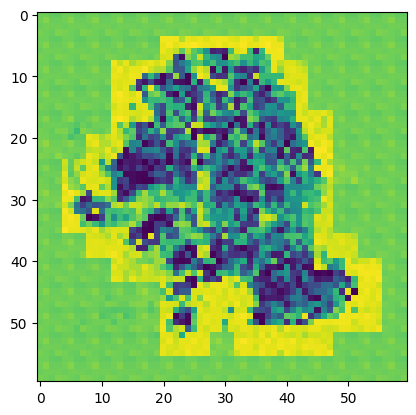

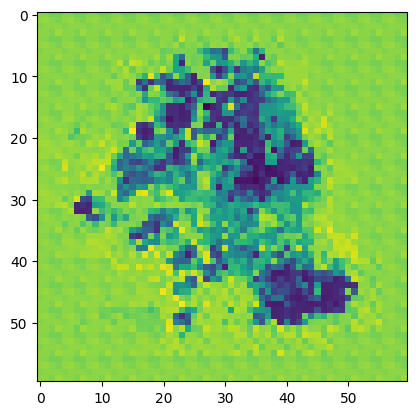

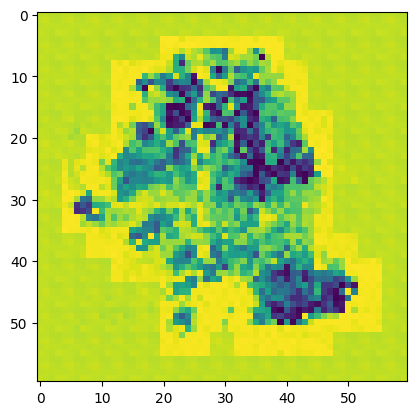

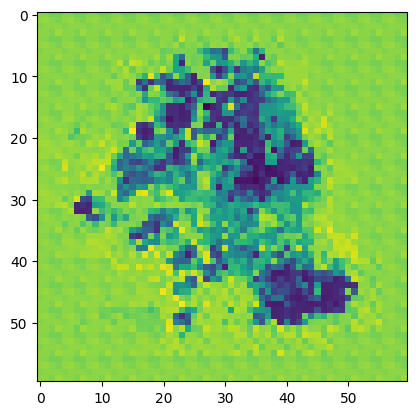

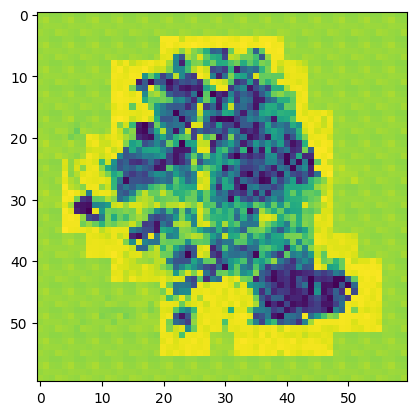

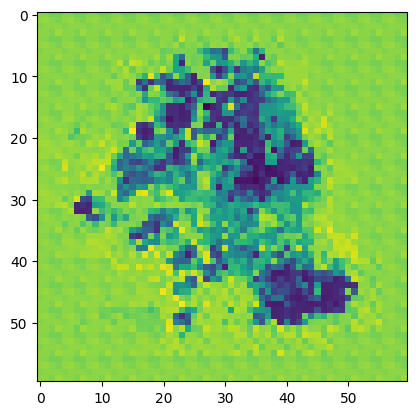

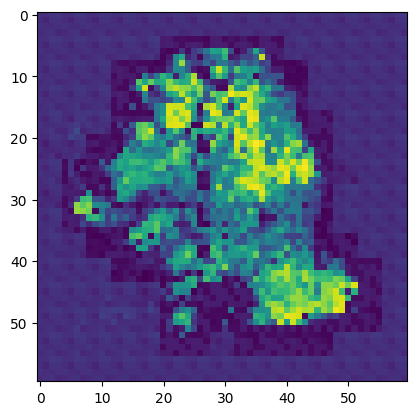

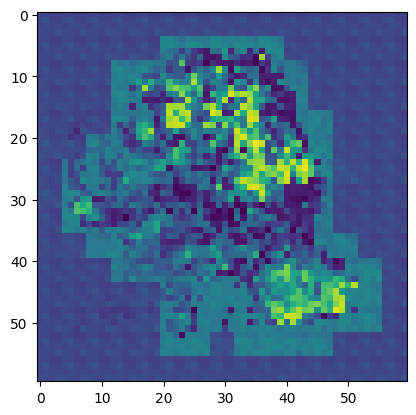

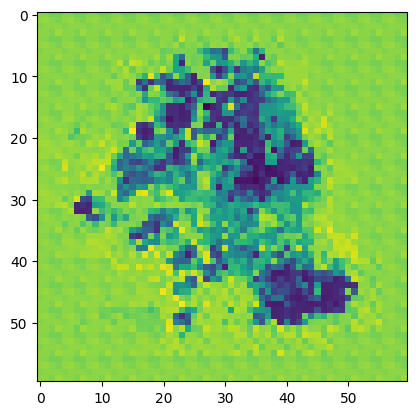

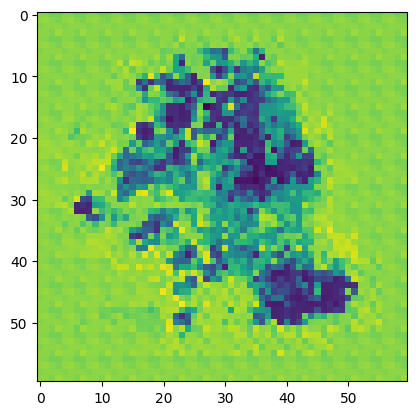

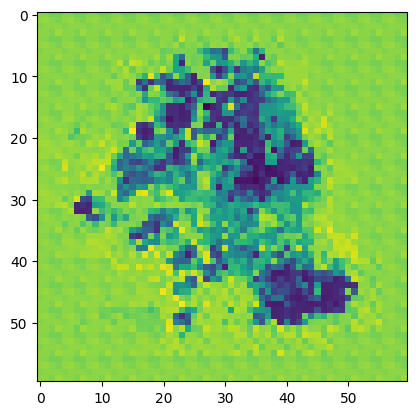

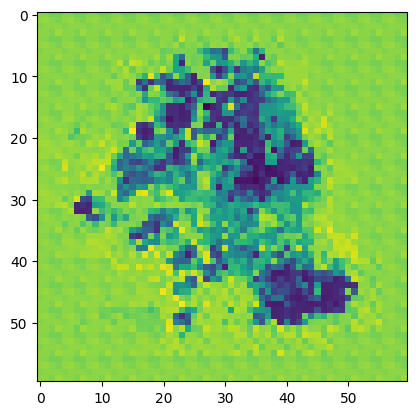

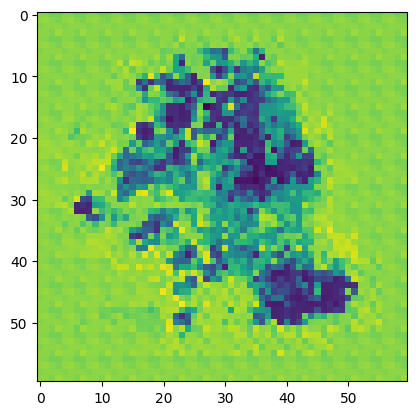

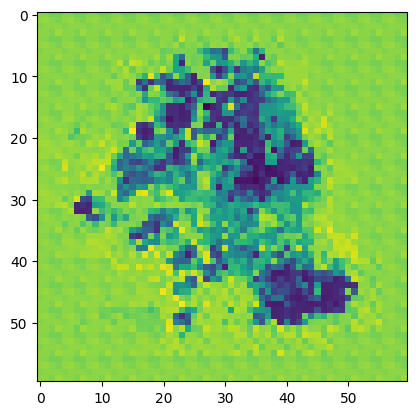

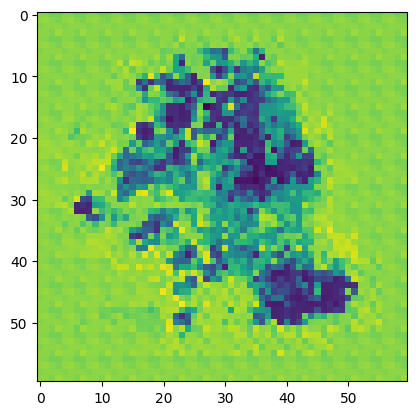

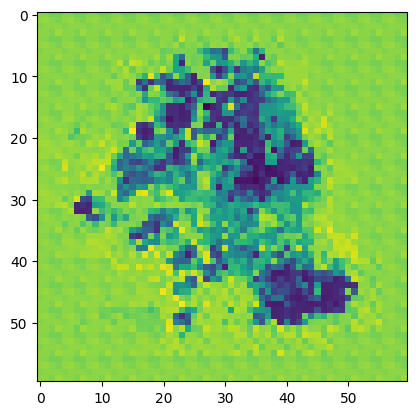

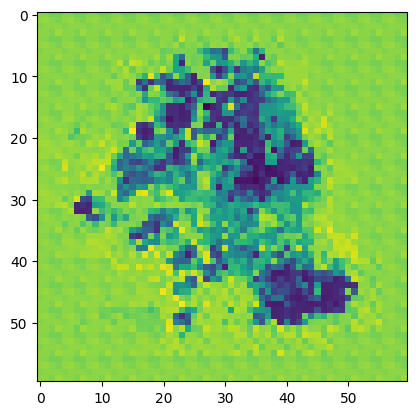

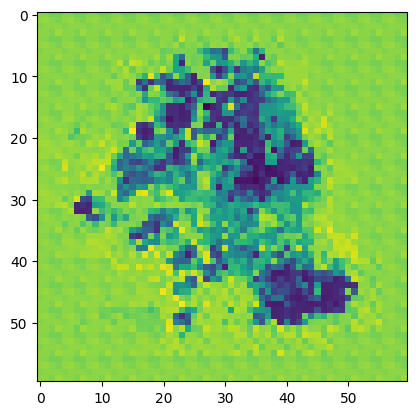

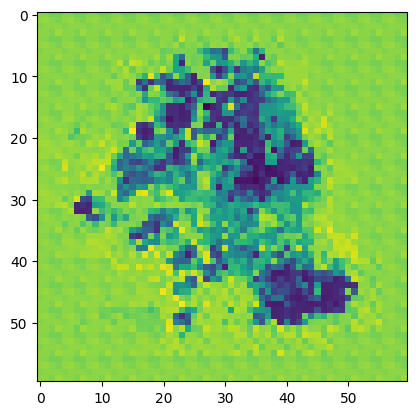

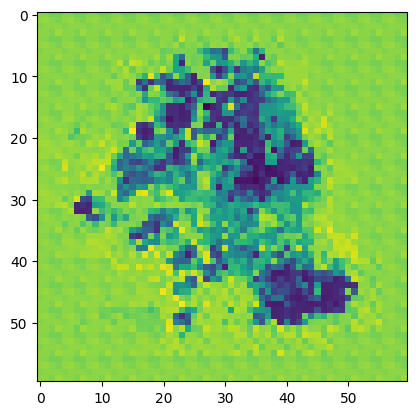

In [20]:
for i in range(20):
    plt.imshow(dists[0, :, :, i])
    plt.show()

In [21]:
# yaml.safe_dump(mushroom_config, open(os.path.join(out_dir, 'mushroom_config.yaml'), 'w'))

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

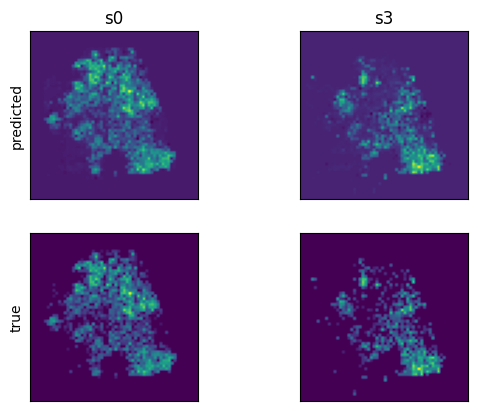

In [27]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

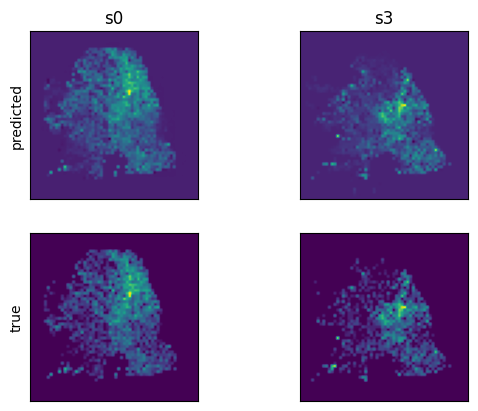

In [28]:
mushroom.display_predicted_pixels(channel='ACTA2')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

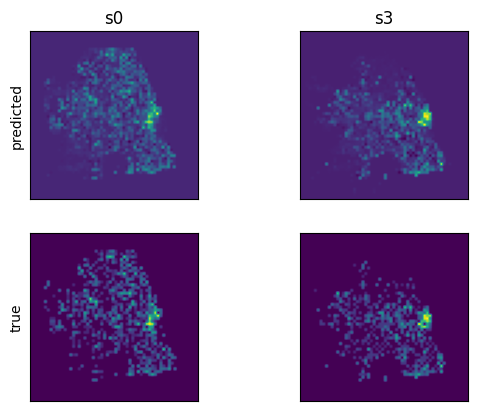

In [29]:
mushroom.display_predicted_pixels(channel='CD68')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

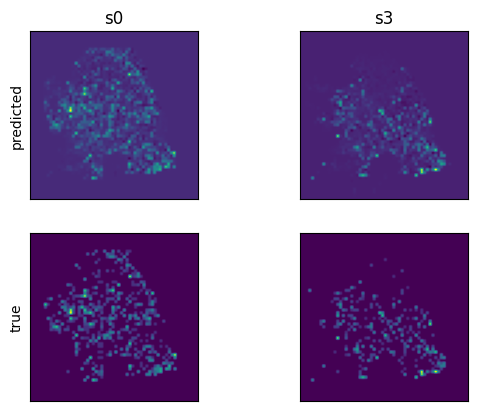

In [47]:
mushroom.display_predicted_pixels(channel='PTPRC')

In [53]:
mushroom.cluster_sections(margin=.1, num_clusters=25)

INFO:root:no background channel detected, defaulting to mean of all channels


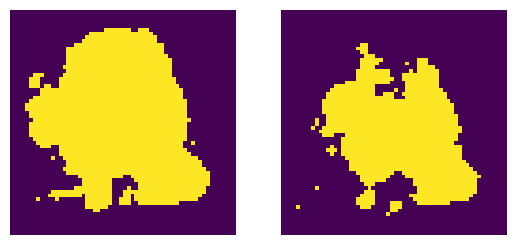

In [54]:
mushroom.clusterer.display_section_masks()

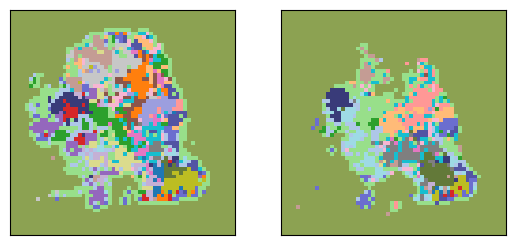

In [55]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

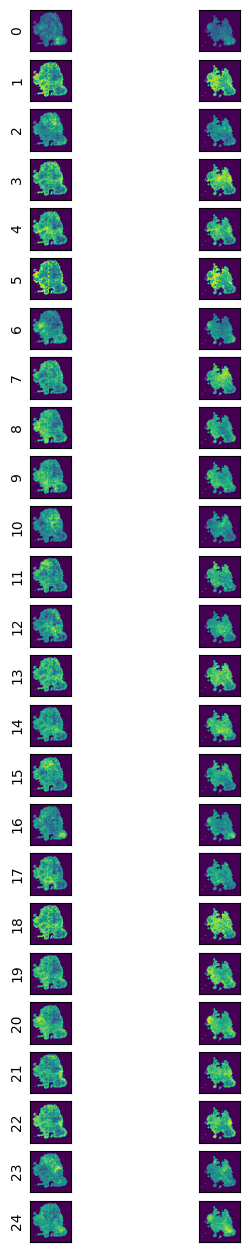

In [56]:
mushroom.clusterer.display_distances(mushroom.dists, figsize=(4, 16))

In [38]:
mushroom.dists_volume.shape

torch.Size([200, 60, 60, 20])

In [ ]:
mushroom.clusterer.display_distances(mushroom.dists_volume, figsize=(10, 14))

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fc81b57f4c0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fc898ddfca0> (for post_execute):
